In [ ]:
!pip install gym
!pip install matplotlib
!pip install scikit-learn

In [ ]:
import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler


matplotlib.style.use('ggplot')

In [ ]:
# Langkah 3: Buat environment
env = gym.make("MountainCar-v0")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# Langkah 4: Preprocessing fitur
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)


StandardScaler()

In [ ]:
# Langkah 5: Buat featurizer
featurizer = sklearn.pipeline.FeatureUnion([
    ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
    ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
    ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
    ("rbf4", RBFSampler(gamma=0.5, n_components=100))
])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(transformer_list=[('rbf1', RBFSampler(gamma=5.0)),
                               ('rbf2', RBFSampler(gamma=2.0)),
                               ('rbf3', RBFSampler()),
                               ('rbf4', RBFSampler(gamma=0.5))])

In [ ]:
# Langkah 6: Definisikan Estimator
class Estimator():
    def __init__(self):
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)

    def featurize_state(self, state):
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]

    def predict(self, s, a=None):
        if a is not None:
            prediction = self.models[a].predict([self.featurize_state(s)])
            return prediction[0]
        else:
            predictions = np.array([self.models[i].predict([self.featurize_state(s)]) for i in range(env.action_space.n)])
            return predictions.reshape(-1)

    def update(self, s, a, y):
        self.models[a].partial_fit([self.featurize_state(s)], [y])

In [ ]:
# Langkah 7: Buat kebijakan epsilon-greedy
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [ ]:
# Langkah 8: Implementasi Q-Learning
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    nA = env.action_space.n
    episode_lengths = np.zeros(num_episodes)
    episode_rewards = np.zeros(num_episodes)

    for i_episode in range(num_episodes):
        policy = make_epsilon_greedy_policy(estimator, epsilon * epsilon_decay**i_episode, nA)
        last_reward = episode_rewards[i_episode - 1] if i_episode > 0 else 0
        print(f"Episode {i_episode + 1}/{num_episodes} ({last_reward})")

        state = env.reset()

        for t in itertools.count():
            action = np.random.choice(nA, p=policy(state))
            new_state, reward, terminated, _ = env.step(action)
            episode_rewards[i_episode] += reward
            episode_lengths[i_episode] = t

            q_values_new_state = estimator.predict(new_state)
            td_target = reward + discount_factor * np.max(q_values_new_state)
            estimator.update(state, action, td_target)

            state = new_state
            if terminated:
                break

    return episode_lengths, episode_rewards

In [ ]:
# Langkah 9: Inisialisasi Estimator dan jalankan Q-Learning
estimator = Estimator()
episode_lengths, episode_rewards = q_learning(env, estimator, 100, epsilon=0.0)

Episode 1/100 (0)


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 2/100 (-200.0)
Episode 3/100 (-200.0)
Episode 4/100 (-200.0)
Episode 5/100 (-200.0)
Episode 6/100 (-200.0)
Episode 7/100 (-200.0)
Episode 8/100 (-200.0)
Episode 9/100 (-200.0)
Episode 10/100 (-200.0)
Episode 11/100 (-200.0)
Episode 12/100 (-200.0)
Episode 13/100 (-200.0)
Episode 14/100 (-200.0)
Episode 15/100 (-200.0)
Episode 16/100 (-200.0)
Episode 17/100 (-200.0)
Episode 18/100 (-200.0)
Episode 19/100 (-200.0)
Episode 20/100 (-200.0)
Episode 21/100 (-200.0)
Episode 22/100 (-200.0)
Episode 23/100 (-200.0)
Episode 24/100 (-200.0)
Episode 25/100 (-200.0)
Episode 26/100 (-200.0)
Episode 27/100 (-200.0)
Episode 28/100 (-200.0)
Episode 29/100 (-200.0)
Episode 30/100 (-200.0)
Episode 31/100 (-174.0)
Episode 32/100 (-200.0)
Episode 33/100 (-200.0)
Episode 34/100 (-200.0)
Episode 35/100 (-171.0)
Episode 36/100 (-200.0)
Episode 37/100 (-200.0)
Episode 38/100 (-169.0)
Episode 39/100 (-200.0)
Episode 40/100 (-200.0)
Episode 41/100 (-200.0)
Episode 42/100 (-167.0)
Episode 43/100 (-200.0)


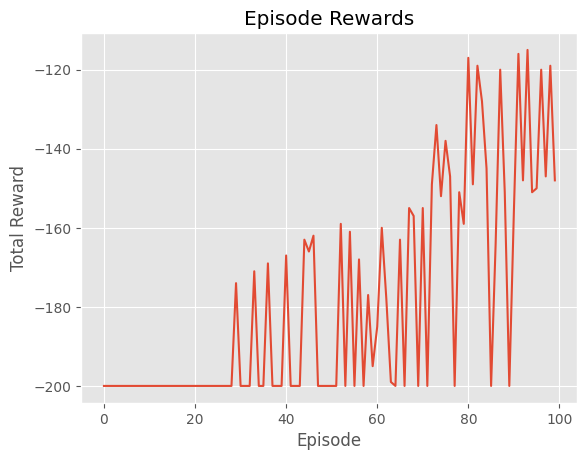

In [ ]:
import matplotlib.pyplot as plt

plt.plot(episode_rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()